In [70]:
# random forest regressor on 20m resolution images
import numpy as np
import pandas as pd
import sklearn
import math

### (1) 데이터 전처리

In [71]:
df = pd.read_csv(r"./../dataset-Icheon&CHL/str_sampling_2000_20m_final_20221108.csv", low_memory = False)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   279 non-null    int64  
 1   xcoord(long)         279 non-null    float64
 2   ycoord(lat)          279 non-null    float64
 3   sampling date        279 non-null    object 
 4   sensing date         279 non-null    object 
 5   B2                   279 non-null    int64  
 6   B3                   279 non-null    int64  
 7   B4                   279 non-null    int64  
 8   B5                   279 non-null    int64  
 9   B6                   279 non-null    int64  
 10  B7                   279 non-null    int64  
 11  B8A                  279 non-null    int64  
 12  B11                  279 non-null    int64  
 13  B12                  279 non-null    int64  
 14  NDVI                 279 non-null    float64
 15  BSI                  279 non-null    flo

In [73]:
df = pd.DataFrame(df[['id','B2','B3','B4','B5','B6','B7','B8A','B11','B12','NDVI','BSI','EVI','AVI','SAVI','NDMI','SWHC','Sand (%)','Silt (%)','Clay (%)','SOC']])

In [74]:
df.head()

,id,B2,B3,B4,B5,B6,B7,B8A,B11,B12,...,BSI,EVI,AVI,SAVI,NDMI,SWHC,Sand (%),Silt (%),Clay (%),SOC
0,1,2020,2555,3095,3264,3774,4137,4234,5107,4041,...,0.134754,0.371979,-2461.869129,0.233099,-0.093459,0.70,68.0,30.5,1.6,0.71
1,1,1640,2002,2397,2781,3036,3232,3188,3986,3095,...,0.138703,0.375166,-1821.351929,0.212425,-0.111235,0.70,68.0,30.5,1.6,0.71
2,1,1929,2325,2793,3124,3434,3429,3635,4849,3928,...,0.157353,0.355184,-2044.453828,0.196469,-0.143093,0.70,68.0,30.5,1.6,0.71
3,1,2387,2955,3646,3441,4298,4607,4869,5624,4324,...,0.121869,0.345734,-2789.467172,0.215431,-0.071953,0.70,68.0,30.5,1.6,0.71
4,2,3075,3914,4958,5340,5515,5755,5967,6441,4969,...,0.115307,0.199352,-3101.858919,0.138529,-0.038201,0.75,75.2,23.6,1.2,0.86


In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [76]:
# normalize1
# band 값만 10000으로 나누기
df['B2'] = df['B2']/10000
df['B3'] = df['B3']/10000
df['B4'] = df['B4']/10000
df['B5'] = df['B5']/10000
df['B6'] = df['B6']/10000
df['B7'] = df['B7']/10000
df['B8A'] = df['B8A']/10000
df['B11'] = df['B11']/10000
df['B12'] = df['B12']/10000


In [77]:
df['AVI'] = df['AVI']/10000
print(df)

     id      B2      B3      B4      B5      B6      B7     B8A     B11  \
0     1  0.2020  0.2555  0.3095  0.3264  0.3774  0.4137  0.4234  0.5107   
1     1  0.1640  0.2002  0.2397  0.2781  0.3036  0.3232  0.3188  0.3986   
2     1  0.1929  0.2325  0.2793  0.3124  0.3434  0.3429  0.3635  0.4849   
3     1  0.2387  0.2955  0.3646  0.3441  0.4298  0.4607  0.4869  0.5624   
4     2  0.3075  0.3914  0.4958  0.5340  0.5515  0.5755  0.5967  0.6441   
..   ..     ...     ...     ...     ...     ...     ...     ...     ...   
274  75  0.2027  0.2407  0.2756  0.3122  0.3377  0.3449  0.3649  0.4283   
275  76  0.1895  0.2369  0.2891  0.3165  0.3277  0.3394  0.3603  0.4378   
276  76  0.1819  0.2208  0.2595  0.2881  0.3015  0.3146  0.3342  0.3940   
277  76  0.2043  0.2483  0.2853  0.3178  0.3425  0.3555  0.3656  0.4255   
278  77  0.1891  0.2344  0.2834  0.3052  0.3162  0.3352  0.3576  0.3887   

        B12  ...       BSI       EVI       AVI      SAVI      NDMI      SWHC  \
0    0.4041  ...  0

In [78]:
df['Sand (%)'] = df['Sand (%)']/100
df['Silt (%)'] = df['Silt (%)']/100
df['Clay (%)'] = df['Clay (%)']/100
df

,id,B2,B3,B4,B5,B6,B7,B8A,B11,B12,...,BSI,EVI,AVI,SAVI,NDMI,SWHC,Sand (%),Silt (%),Clay (%),SOC
0,1,0.2020,0.2555,0.3095,0.3264,0.3774,0.4137,0.4234,0.5107,0.4041,...,0.134754,0.371979,-0.246187,0.233099,-0.093459,0.700000,0.680000,0.305,0.016000,0.71
1,1,0.1640,0.2002,0.2397,0.2781,0.3036,0.3232,0.3188,0.3986,0.3095,...,0.138703,0.375166,-0.182135,0.212425,-0.111235,0.700000,0.680000,0.305,0.016000,0.71
2,1,0.1929,0.2325,0.2793,0.3124,0.3434,0.3429,0.3635,0.4849,0.3928,...,0.157353,0.355184,-0.204445,0.196469,-0.143093,0.700000,0.680000,0.305,0.016000,0.71
3,1,0.2387,0.2955,0.3646,0.3441,0.4298,0.4607,0.4869,0.5624,0.4324,...,0.121869,0.345734,-0.278947,0.215431,-0.071953,0.700000,0.680000,0.305,0.016000,0.71
4,2,0.3075,0.3914,0.4958,0.5340,0.5515,0.5755,0.5967,0.6441,0.4969,...,0.115307,0.199352,-0.310186,0.138529,-0.038201,0.750000,0.752000,0.236,0.012000,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,75,0.2027,0.2407,0.2756,0.3122,0.3377,0.3449,0.3649,0.4283,0.3924,...,0.107196,0.447978,-0.207834,0.209117,-0.079929,0.600000,0.953586,0.000,0.046414,3.22
275,76,0.1895,0.2369,0.2891,0.3165,0.3277,0.3394,0.3603,0.4378,0.3873,...,0.138717,0.264193,-0.194991,0.164447,-0.097106,0.733333,0.945525,0.000,0.054475,3.30
276,76,0.1819,0.2208,0.2595,0.2881,0.3015,0.3146,0.3342,0.3940,0.3566,...,0.117476,0.354331,-0.186394,0.188716,-0.082120,0.733333,0.945525,0.000,0.054475,3.30
277,76,0.2043,0.2483,0.2853,0.3178,0.3425,0.3555,0.3656,0.4255,0.3901,...,0.110018,0.368180,-0.203060,0.185037,-0.075717,0.733333,0.945525,0.000,0.054475,3.30


In [79]:
x = df.iloc[:, :-1]
print(x)

     id      B2      B3      B4      B5      B6      B7     B8A     B11  \
0     1  0.2020  0.2555  0.3095  0.3264  0.3774  0.4137  0.4234  0.5107   
1     1  0.1640  0.2002  0.2397  0.2781  0.3036  0.3232  0.3188  0.3986   
2     1  0.1929  0.2325  0.2793  0.3124  0.3434  0.3429  0.3635  0.4849   
3     1  0.2387  0.2955  0.3646  0.3441  0.4298  0.4607  0.4869  0.5624   
4     2  0.3075  0.3914  0.4958  0.5340  0.5515  0.5755  0.5967  0.6441   
..   ..     ...     ...     ...     ...     ...     ...     ...     ...   
274  75  0.2027  0.2407  0.2756  0.3122  0.3377  0.3449  0.3649  0.4283   
275  76  0.1895  0.2369  0.2891  0.3165  0.3277  0.3394  0.3603  0.4378   
276  76  0.1819  0.2208  0.2595  0.2881  0.3015  0.3146  0.3342  0.3940   
277  76  0.2043  0.2483  0.2853  0.3178  0.3425  0.3555  0.3656  0.4255   
278  77  0.1891  0.2344  0.2834  0.3052  0.3162  0.3352  0.3576  0.3887   

        B12      NDVI       BSI       EVI       AVI      SAVI      NDMI  \
0    0.4041  0.155410  0

In [80]:
y = df.iloc[:, -1:]

In [81]:
print(y)

      SOC
0    0.71
1    0.71
2    0.71
3    0.71
4    0.86
..    ...
274  3.22
275  3.30
276  3.30
277  3.30
278  2.51

[279 rows x 1 columns]


### (2) 데이터 샘플링

적은 양의 데이터의 경우, 샘플링 시 계층적 샘플링(Stratified sampling)을 해야 전체 데이터셋의 분포와 비슷하게 서브셋 데이터를 샘플링 할 수 있다.

In [109]:
# tf.random.set_seed(21) 
np.random.seed(21)

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns


In [83]:
df = pd.DataFrame(x)
df['SOC']= y
df

,id,B2,B3,B4,B5,B6,B7,B8A,B11,B12,...,BSI,EVI,AVI,SAVI,NDMI,SWHC,Sand (%),Silt (%),Clay (%),SOC
0,1,0.2020,0.2555,0.3095,0.3264,0.3774,0.4137,0.4234,0.5107,0.4041,...,0.134754,0.371979,-0.246187,0.233099,-0.093459,0.700000,0.680000,0.305,0.016000,0.71
1,1,0.1640,0.2002,0.2397,0.2781,0.3036,0.3232,0.3188,0.3986,0.3095,...,0.138703,0.375166,-0.182135,0.212425,-0.111235,0.700000,0.680000,0.305,0.016000,0.71
2,1,0.1929,0.2325,0.2793,0.3124,0.3434,0.3429,0.3635,0.4849,0.3928,...,0.157353,0.355184,-0.204445,0.196469,-0.143093,0.700000,0.680000,0.305,0.016000,0.71
3,1,0.2387,0.2955,0.3646,0.3441,0.4298,0.4607,0.4869,0.5624,0.4324,...,0.121869,0.345734,-0.278947,0.215431,-0.071953,0.700000,0.680000,0.305,0.016000,0.71
4,2,0.3075,0.3914,0.4958,0.5340,0.5515,0.5755,0.5967,0.6441,0.4969,...,0.115307,0.199352,-0.310186,0.138529,-0.038201,0.750000,0.752000,0.236,0.012000,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,75,0.2027,0.2407,0.2756,0.3122,0.3377,0.3449,0.3649,0.4283,0.3924,...,0.107196,0.447978,-0.207834,0.209117,-0.079929,0.600000,0.953586,0.000,0.046414,3.22
275,76,0.1895,0.2369,0.2891,0.3165,0.3277,0.3394,0.3603,0.4378,0.3873,...,0.138717,0.264193,-0.194991,0.164447,-0.097106,0.733333,0.945525,0.000,0.054475,3.30
276,76,0.1819,0.2208,0.2595,0.2881,0.3015,0.3146,0.3342,0.3940,0.3566,...,0.117476,0.354331,-0.186394,0.188716,-0.082120,0.733333,0.945525,0.000,0.054475,3.30
277,76,0.2043,0.2483,0.2853,0.3178,0.3425,0.3555,0.3656,0.4255,0.3901,...,0.110018,0.368180,-0.203060,0.185037,-0.075717,0.733333,0.945525,0.000,0.054475,3.30


In [134]:
# id 대표 하나씩만 
index_count = x['id'].value_counts()

king_list = [0]
sum = 0
for i in range(1, len(index_count)):
    sum += index_count[i] 
    king_list.append(sum)

print(king_list)
king_df = pd.DataFrame(df.iloc[king_list,:])
king_df['idx'] = king_df.index
king_df.reset_index(drop=True, inplace=True)
king_df

[0, 4, 9, 14, 19, 22, 26, 29, 35, 41, 47, 52, 53, 58, 64, 70, 74, 78, 82, 87, 91, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 148, 151, 152, 153, 154, 158, 162, 166, 170, 174, 180, 185, 191, 195, 199, 203, 207, 211, 214, 218, 222, 225, 228, 231, 234, 237, 240, 244, 248, 252, 256, 260, 263, 266, 269, 272, 275, 278]


,id,B2,B3,B4,B5,B6,B7,B8A,B11,B12,...,AVI,SAVI,NDMI,SWHC,Sand (%),Silt (%),Clay (%),SOC,SOC Cat,idx
0,1,0.2020,0.2555,0.3095,0.3264,0.3774,0.4137,0.4234,0.5107,0.4041,...,-0.246187,0.233099,-0.093459,0.700000,0.680000,0.305,0.016000,0.71,2,0
1,2,0.3075,0.3914,0.4958,0.5340,0.5515,0.5755,0.5967,0.6441,0.4969,...,-0.310186,0.138529,-0.038201,0.750000,0.752000,0.236,0.012000,0.86,3,4
2,3,0.2955,0.3741,0.4904,0.5519,0.5619,0.5813,0.5986,0.6298,0.4692,...,-0.316671,0.149029,-0.025399,0.800000,0.638000,0.335,0.027000,0.87,3,9
3,4,0.2907,0.3692,0.4737,0.5347,0.5423,0.5666,0.5909,0.6465,0.4969,...,-0.320099,0.165125,-0.044933,1.000000,0.778000,0.176,0.047000,1.00,4,14
4,5,0.2753,0.3298,0.3778,0.3928,0.4175,0.4433,0.4638,0.5442,0.4830,...,-0.246978,0.153270,-0.079762,0.700000,0.811000,0.160,0.029000,0.84,3,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,0.1799,0.2241,0.2754,0.3021,0.3241,0.3387,0.3710,0.4300,0.3747,...,-0.213737,0.221827,-0.073658,0.600000,1.000000,0.000,0.000000,2.37,5,266
73,74,0.1807,0.2217,0.2735,0.3043,0.3158,0.3345,0.3633,0.4214,0.3699,...,-0.207386,0.211510,-0.074041,0.700000,0.935829,0.000,0.064171,3.68,5,269
74,75,0.1847,0.2259,0.2806,0.3105,0.3303,0.3439,0.3690,0.4349,0.3790,...,-0.209156,0.204110,-0.081975,0.600000,0.953586,0.000,0.046414,3.22,5,272
75,76,0.1895,0.2369,0.2891,0.3165,0.3277,0.3394,0.3603,0.4378,0.3873,...,-0.194991,0.164447,-0.097106,0.733333,0.945525,0.000,0.054475,3.30,5,275


1    16
3    16
4    16
2    15
5    14
Name: SOC Cat, dtype: int64


<AxesSubplot:>

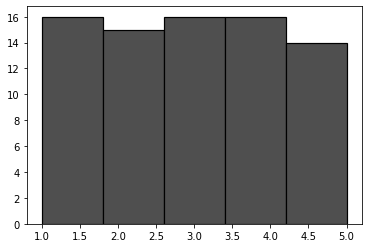

In [135]:
dist = [0.,
        king_df['SOC'].quantile(q=0.2,interpolation='nearest'),
        king_df['SOC'].quantile(q=0.4,interpolation='nearest'),
        king_df['SOC'].quantile(q=0.6,interpolation='nearest'),
        king_df['SOC'].quantile(q=0.8,interpolation='nearest'),
        np.inf]


king_df['SOC Cat'] = pd.cut(king_df['SOC'],
                        bins=dist, 
                        labels=[1,2,3,4,5]) # SOC 정도에 대한 카테고리 설정

# check 
print(king_df['SOC Cat'].value_counts())
king_df['SOC Cat'].hist(color='#4F4F4F', grid=False, bins=5, edgecolor='black', linewidth=1.2)

(57, 23) (20, 23)


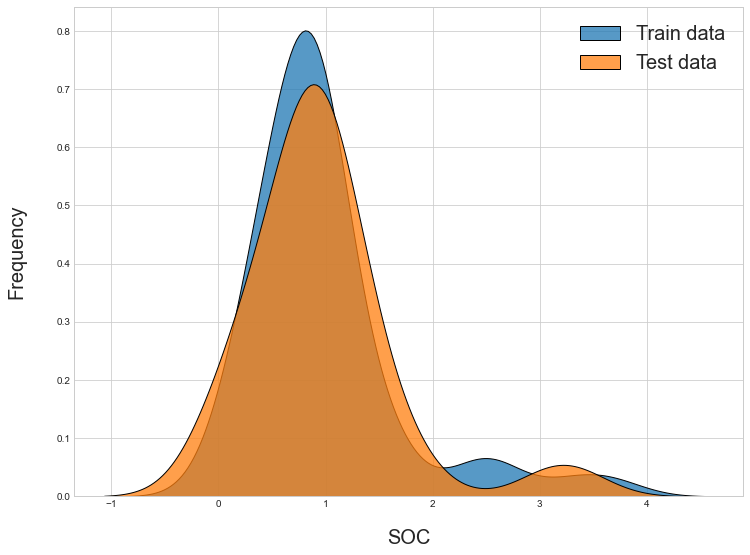

In [289]:
# Sampling based on caterogries
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_idx, test_idx in split.split(king_df, king_df['SOC Cat']):
    strat_train = king_df.loc[train_idx]
    strat_test = king_df.loc[test_idx]

# check
print(strat_train.shape, strat_test.shape)

plt.figure(figsize=(12,9))
sns.kdeplot(strat_train['SOC'], fill=True , label="Train data", multiple='stack')
sns.kdeplot(strat_test['SOC'], fill=True,  label="Test data", multiple='stack')

plt.legend(fontsize=20)
plt.xlabel('SOC', fontsize=20, labelpad=20)
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.show()


증가시킨 데이터셋에서의 학습, 테스트 데이터셋 인덱스 재설정

In [249]:
str_train_idx, str_test_idx = [], []
for i in train_idx:
    indx = king_df.iloc[i,-1]
    length = index_count[i+1]
    for j in range(length):
        str_train_idx.append(indx+j)

for i in test_idx:
    indx = king_df.iloc[i,-1]
    length = index_count[i+1]
    for j in range(length):
        str_test_idx.append(indx+j)

# print(str_train_idx, str_test_idx)

In [250]:
train = df.loc[str_train_idx]
test = df.loc[str_test_idx]

In [251]:
train

,id,B2,B3,B4,B5,B6,B7,B8A,B11,B12,...,EVI,AVI,SAVI,NDMI,SWHC,Sand (%),Silt (%),Clay (%),SOC,SOC Cat
180,50,0.3164,0.4006,0.5006,0.5500,0.5619,0.5845,0.5988,0.7115,0.5247,...,0.199675,-0.308744,0.133976,-0.086011,0.600000,0.556667,0.443333,0.000000,0.45,1
181,50,0.3236,0.4146,0.5039,0.5465,0.5606,0.5713,0.5780,0.7103,0.5216,...,0.157727,-0.278399,0.102731,-0.102693,0.600000,0.556667,0.443333,0.000000,0.45,1
182,50,0.2313,0.2935,0.3669,0.3921,0.4079,0.4171,0.4152,0.5469,0.3979,...,0.136913,-0.194481,0.092629,-0.136888,0.600000,0.556667,0.443333,0.000000,0.45,1
183,50,0.2846,0.3746,0.4677,0.5128,0.5349,0.5398,0.5472,0.7037,0.4906,...,0.163043,-0.272979,0.117493,-0.125110,0.600000,0.556667,0.443333,0.000000,0.45,1
184,50,0.3155,0.3996,0.4943,0.5446,0.5451,0.5690,0.5651,0.7312,0.5557,...,0.151964,-0.270409,0.100241,-0.128134,0.600000,0.556667,0.443333,0.000000,0.45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,31,0.2552,0.3410,0.4276,0.4747,0.4862,0.4993,0.5041,0.6168,0.5022,...,0.165470,-0.254510,0.123155,-0.100544,0.666667,0.611549,0.238845,0.149606,0.91,3
207,56,0.2384,0.3054,0.3982,0.4527,0.4671,0.4797,0.5038,0.5934,0.4429,...,0.238892,-0.276676,0.175600,-0.081662,0.633333,0.589080,0.410920,0.000000,0.50,2
208,56,0.2081,0.2668,0.3312,0.3798,0.4013,0.4175,0.4182,0.5015,0.3871,...,0.257473,-0.229238,0.174128,-0.090573,0.633333,0.589080,0.410920,0.000000,0.50,2
209,56,0.2396,0.3162,0.3864,0.4465,0.4719,0.4810,0.4991,0.5836,0.4493,...,0.276063,-0.279048,0.190898,-0.078046,0.633333,0.589080,0.410920,0.000000,0.50,2


x, y 나누기

In [252]:
x_train = train.loc[:,'B2':'Clay (%)']
y_train = train.loc[:,'SOC']

x_test = test.loc[:,'B2':'Clay (%)']
y_test = test.loc[:,'SOC']


### (3) 모델링

In [253]:
##########모델 생성
model = RandomForestRegressor(
                            # n_estimators=200,
                            # min_samples_leaf = 4,
                            # min_samples_split = 8,
                            )

model.fit(x_train, y_train.ravel())

##########모델 검증
# R-squared
train_result = model.score(x_train, y_train)
print(train_result) #

test_result = model.score(x_test, y_test)
print(test_result)


0.9849432381211508
0.7155544185975823


### (4) 모델 결과

In [254]:
# R-squared
x = pd.DataFrame(x_train.append(x_test))
y = pd.DataFrame(y_train.append(y_test))

model.score(x, y)

C:\Users\uyoung\AppData\Local\Temp\ipykernel_34944\3270960581.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = pd.DataFrame(x_train.append(x_test))
C:\Users\uyoung\AppData\Local\Temp\ipykernel_34944\3270960581.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = pd.DataFrame(y_train.append(y_test))


0.9225379519641057

In [255]:
print(x.shape)
print(model.predict(x).shape)
print(y.shape)

(279, 19)
(279,)
(279, 1)


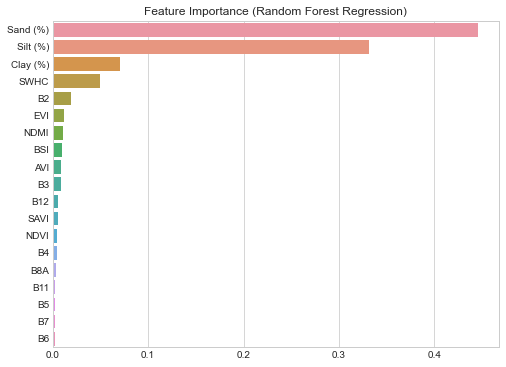

In [256]:
# feature importance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.title('Feature Importance (Random Forest Regression)')
plt.show()

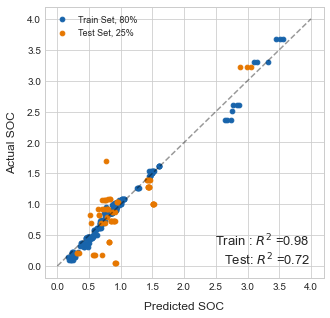

In [288]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(model.predict(x_train), y_train, color='#1864AB', label='Train Set, 80%', s=22)
ax.scatter(model.predict(x_test), y_test, color='#E67700', label='Test Set, 25%', s=22)

font = {'size':12}
font2 = {'size':14}
ax.set_xlabel("Predicted SOC", labelpad=10, fontdict=font)
ax.set_ylabel("Actual SOC", labelpad=10, fontdict=font)
ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_title('Boosting Ensemble', fontdict=font2)
ax.legend(fontsize=9, loc="upper left")

# y=x dashed line
ax.plot([0,4.0], [0,4.0], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.05, f"Train : $R^2$ ={train_result:0.2f}\nTest: $R^2$ ={test_result:0.2f}",
        transform=ax.transAxes, fontsize=13, ha="right")

plt.savefig(f"./str_sampling_GradientBoostingRegressor_performance.png")

In [195]:
# output to csv

output = model.predict(x)
output = pd.DataFrame(output)
output.to_csv(path_or_buf='./../Outputs/str_sampling_rf_20_S2A_SWHC_ST.csv', header=False, index=False)